In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

from IPython.display import clear_output
from keras.models import Model
from keras.preprocessing import image
from keras.callbacks import Callback
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K
from keras.metrics import MeanIoU

In [24]:
import UNet_impl2 as unet

In [25]:
DIR_PATH = '../camVid/CamVid/'
class_dict = pd.read_csv(os.path.join(DIR_PATH + 'class_dict.csv'), index_col=0)
class_dict.head()

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


In [26]:
cls2rgb = {cl:list(class_dict.loc[cl, :]) for cl in class_dict.index}
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
idx2rgb

{0: array([ 64, 128,  64]),
 1: array([192,   0, 128]),
 2: array([  0, 128, 192]),
 3: array([  0, 128,  64]),
 4: array([128,   0,   0]),
 5: array([ 64,   0, 128]),
 6: array([ 64,   0, 192]),
 7: array([192, 128,  64]),
 8: array([192, 192, 128]),
 9: array([ 64,  64, 128]),
 10: array([128,   0, 192]),
 11: array([192,   0,  64]),
 12: array([128, 128,  64]),
 13: array([192,   0, 192]),
 14: array([128,  64,  64]),
 15: array([ 64, 192, 128]),
 16: array([64, 64,  0]),
 17: array([128,  64, 128]),
 18: array([128, 128, 192]),
 19: array([  0,   0, 192]),
 20: array([192, 128, 128]),
 21: array([128, 128, 128]),
 22: array([ 64, 128, 192]),
 23: array([ 0,  0, 64]),
 24: array([ 0, 64, 64]),
 25: array([192,  64, 128]),
 26: array([128, 128,   0]),
 27: array([192, 128, 192]),
 28: array([64,  0, 64]),
 29: array([192, 192,   0]),
 30: array([0, 0, 0]),
 31: array([ 64, 192,   0])}

In [27]:
class CamVidDataset():
    def __init__(self, DIR_PATH):
        self.train_images = self.readData(os.path.join(DIR_PATH + 'train'))
        self.train_masks = self.readData(os.path.join(DIR_PATH + 'train_labels'))
        self.test_images = self.readData(os.path.join(DIR_PATH + 'test'))
        self.test_masks = self.readData(os.path.join(DIR_PATH + 'test_labels'))
        self.val_images = self.readData(os.path.join(DIR_PATH + 'val'))
        self.val_masks = self.readData(os.path.join(DIR_PATH + 'val_labels'))
        self.arr_col = []

        for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
            self.arr_col.append([r, g, b]) 

                                          
    def readData(self, DirPath, max_instances=50):
        img_names = []
        i = 0
        for f in os.listdir(DirPath):
            if i == max_instances:
                break
            i+=1
            img_names.append(os.path.join(DirPath,f))
        img_names.sort()
        
        res = []
        
        for i in img_names:
            res.append(image.load_img(i, target_size=(128, 128)))
        return np.array(res)

    def images_to_arrays(self, images):
        res = []
        for img in images:
            x = image.img_to_array(img)
            res.append(x)
        res = np.array(res)
        print(res.shape)
        return res

        
    def color2index(self, y):
        y_ind = np.zeros((y.shape[0], y.shape[1]))
        y_cat = np.zeros((y.shape[0], y.shape[1], len(self.arr_col)))
        i = 1
        for i_color in self.arr_col:
            ind_i = np.where(
                (y[..., 0] == i_color[0]) 
                & (y[..., 1] == i_color[1])
                & (y[..., 2] == i_color[2])
            )
            y_ind[ind_i[0], ind_i[1]] = i
            y_cat[ind_i[0], ind_i[1], i-1] = 1 
            i += 1
        return y_cat, y_ind#, i-1

    def masks_to_arrays(self, masks):
        res = []
        for mask in masks:
            cat, _ = self.color2index(image.img_to_array(mask))
            res.append(cat)
        res = np.array(res)
        print(res.shape)
        return res

    def split_images(self):
        return (self.images_to_arrays(self.train_images),
                self.images_to_arrays(self.test_images),
                self.images_to_arrays(self.val_images))
    
    def split_masks(self):
        return (self.masks_to_arrays(self.train_masks),
                self.masks_to_arrays(self.test_masks),
                self.masks_to_arrays(self.val_masks))

In [28]:
dataset = CamVidDataset(DIR_PATH)

/tmp/ipykernel_116428/1476802229.py:29: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(res)
/tmp/ipykernel_116428/1476802229.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(res)


In [29]:
(X_train, X_test, X_val) = dataset.split_images()
(y_train, y_test, y_val) = dataset.split_masks()

(50, 128, 128, 3)
(50, 128, 128, 3)
(50, 128, 128, 3)
(50, 128, 128, 32)
(50, 128, 128, 32)
(50, 128, 128, 32)


In [30]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [31]:
model = unet.build_unet(32, (128, 128, 3))
model.compile(
  optimizer='adam',
  loss=bce_dice_loss,
  metrics=[iou, dice_coef, tf.keras.metrics.MeanIoU(num_classes=32), 'accuracy'])
model.load_weights('models/model4/model4')

In [32]:
loss, iou, dice, mIoU, acc = model.evaluate(X_train, y_train, verbose=2)
print("Restored model, mIoU:{:5.2f}%".format( mIoU*100))

/home/isidora/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 - 13s - loss: 0.6494 - iou: 0.3799 - dice_coef: 0.5504 - mean_io_u_1: 0.5022 - accuracy: 0.5468 - 13s/epoch - 6s/step
Restored model, mIoU:50.22%


In [33]:
loss, iou, dice, mIoU, acc = model.evaluate(X_val, y_val, verbose=2)
print("Restored model, mIoU:{:5.2f}%".format( mIoU*100))

2/2 - 17s - loss: 0.6201 - iou: 0.4027 - dice_coef: 0.5731 - mean_io_u_1: 0.5059 - accuracy: 0.5636 - 17s/epoch - 9s/step
Restored model, mIoU:50.59%


In [34]:
loss, iou, dice, mIoU, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, mIoU:{:5.2f}%".format( mIoU*100))

2/2 - 14s - loss: 0.6853 - iou: 0.3656 - dice_coef: 0.5332 - mean_io_u_1: 0.4994 - accuracy: 0.5187 - 14s/epoch - 7s/step
Restored model, mIoU:49.94%


In [35]:
def map_class_to_rgb(p):
    return idx2rgb[p[0]]

def show_prediction(model, ind, dataset_images, dataset_masks, images):
    img = images[ind]
    img = np.expand_dims(img,axis=0) # (128, 128, 3)
    pred_mask = model.predict(img) # (1, 128, 128, 3)
    pred_mask = np.argmax(pred_mask, axis=-1) # (1, 128, 128)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
    rgb_mask = rgb_mask.reshape((128, 128, 3))
    fig, ax = plt.subplots(1, 3, figsize=(12, 12))
    ax[0].imshow(dataset_images[ind].convert('RGBA'))
    ax[1].imshow(dataset_masks[ind])
    ax[2].imshow(rgb_mask)
    plt.show()

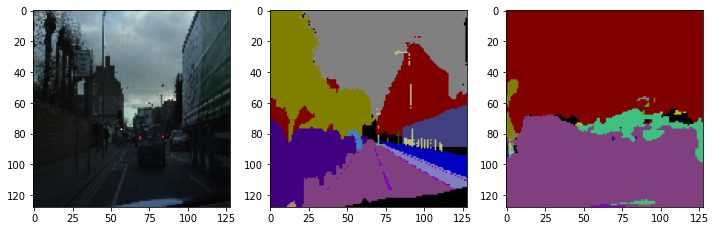

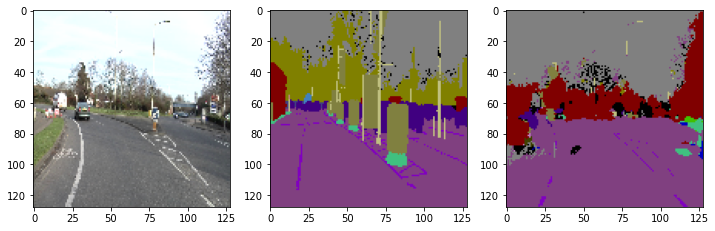

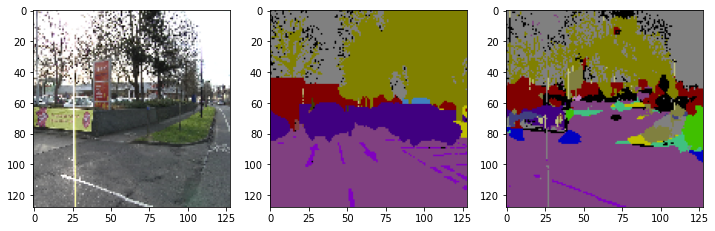

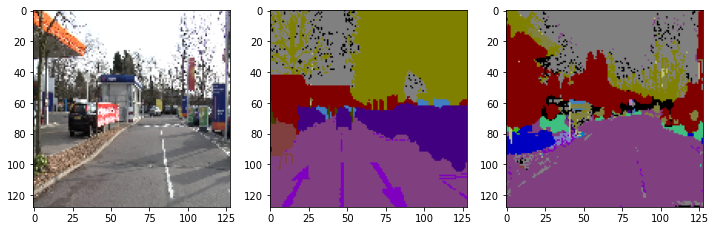

In [36]:
for i in range(4):
    show_prediction(model, i, dataset.train_images, dataset.train_masks, X_train)

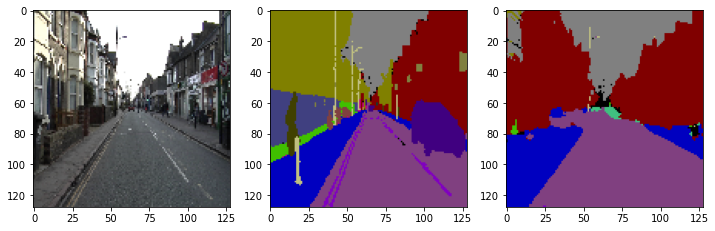

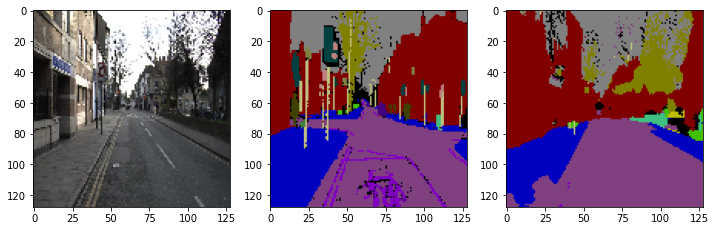

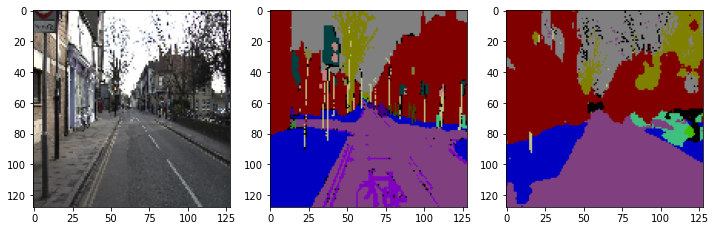

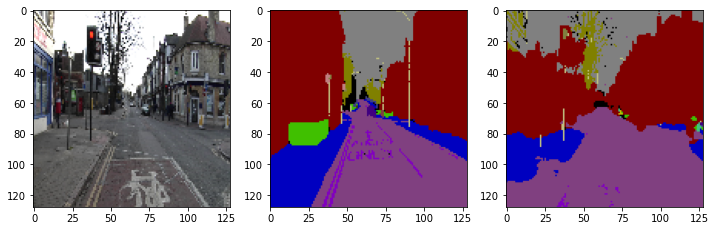

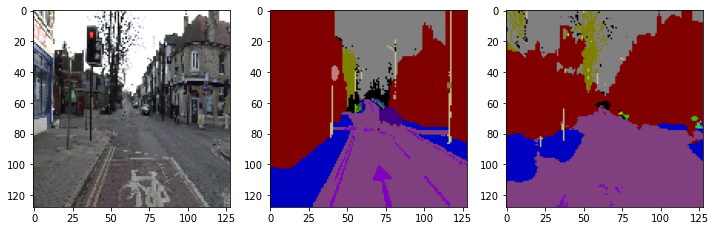

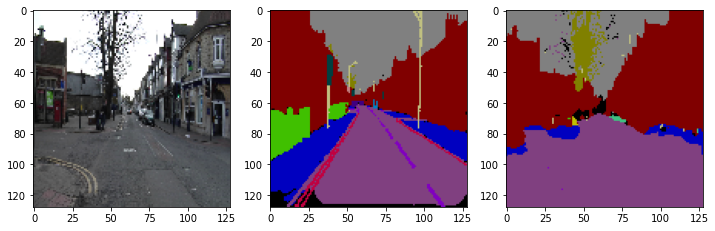

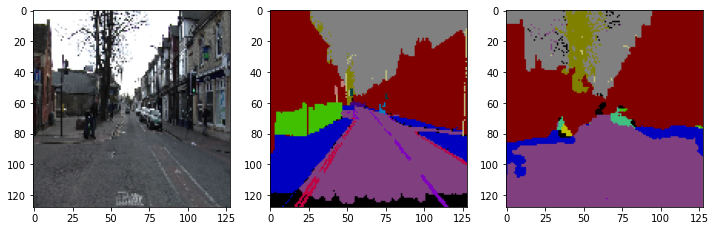

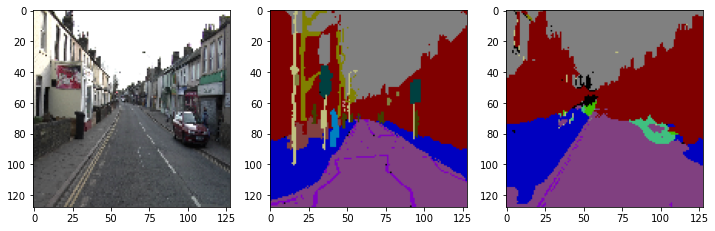

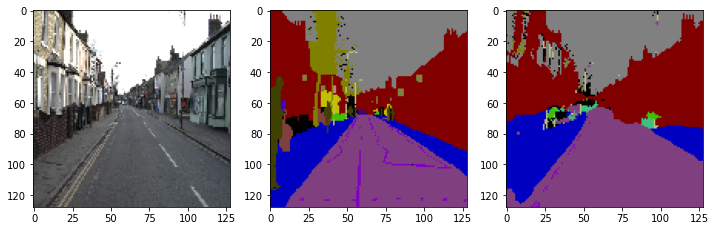

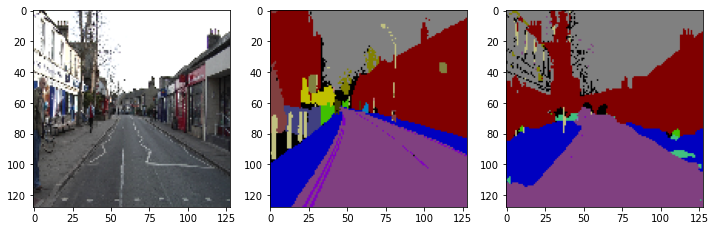

In [37]:
for i in range(10):
    show_prediction(model, i+40, dataset.val_images, dataset.val_masks, X_val)

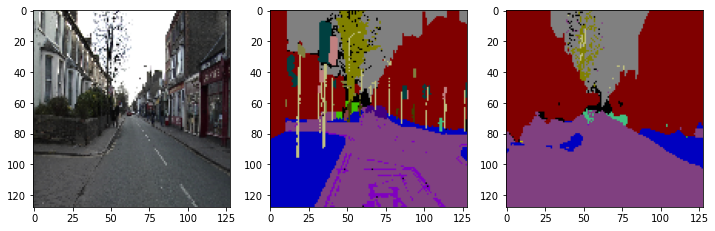

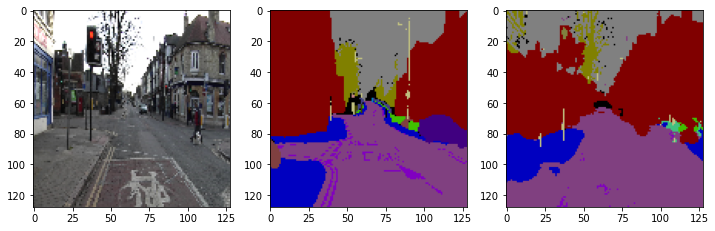

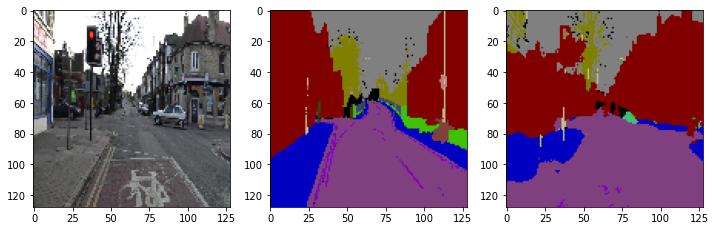

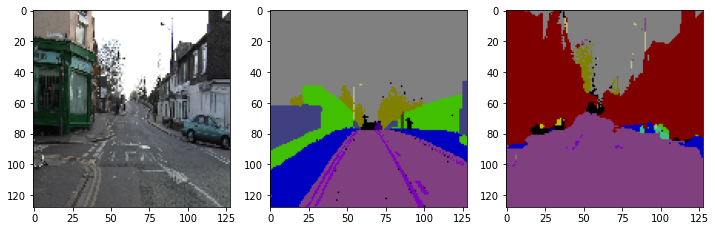

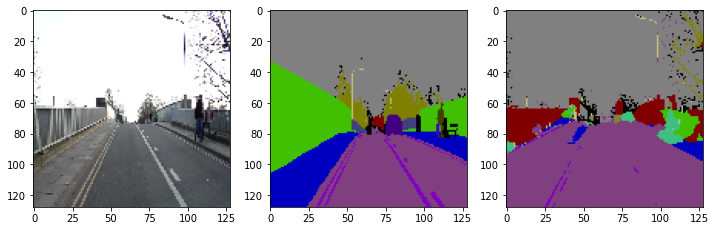

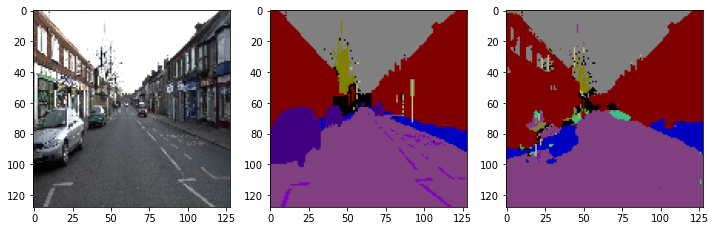

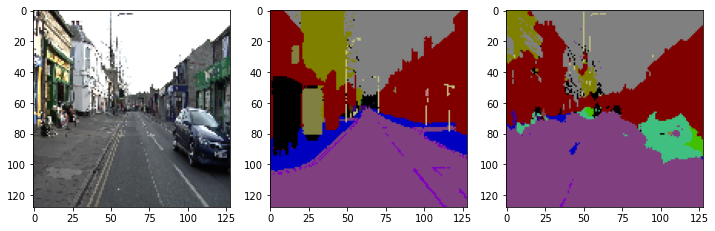

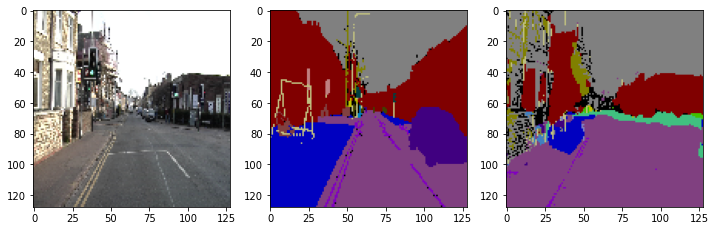

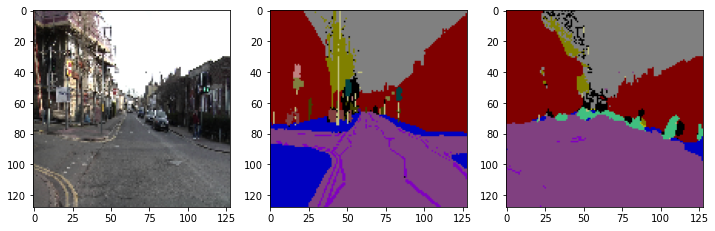

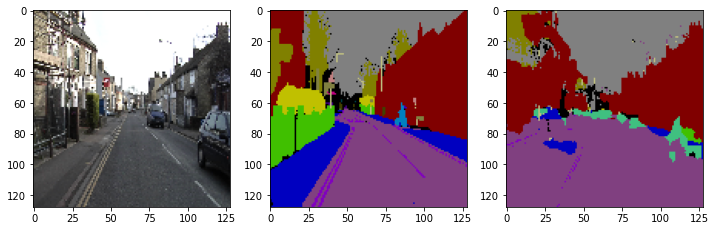

In [38]:
for i in range(10):
    show_prediction(model, i+40, dataset.test_images, dataset.test_masks, X_test)

In [39]:
import imageio

In [40]:
def create_predictions(model, images):
    predictions = []
    for img in images:
        img = np.expand_dims(img,axis=0)
        pred_mask = model.predict(img)
        pred_mask = np.argmax(pred_mask, axis=-1)
        rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
        rgb_mask = rgb_mask.reshape((128, 128, 3))
        predictions.append(rgb_mask)
    return predictions

def create_gif(gif_name, images):
    with imageio.get_writer(gif_name, mode='I') as writer:
        for img in images:
            writer.append_data(image.img_to_array(img))

In [41]:
create_gif('train_predicted_masks4.gif', create_predictions(model, X_train))
create_gif('val_predicted_masks4.gif', create_predictions(model, X_val))
create_gif('test_predicted_masks4.gif', create_predictions(model, X_test))

Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 192.0]. Convert image to uint8 prior to saving to suppress this warning.
